In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_raw=pd.read_csv('../content/water_potability.csv')

# drop Nan data and reset index
df_dropped = df_raw.dropna()
df = df_dropped.reset_index(drop=True)
print("raw data has", len(df_raw), " after drop has",  len(df))

df.head()

X = df.drop('Potability',axis=1).values
y = df['Potability'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


# [     train        |  test  ]
# [   |   |   |   |  ]

# "We split train test in 70/30. And use x-fold CV on the train to determine the best hyperparameter setup"

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

raw data has 3276  after drop has 2011


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve

In [ ]:
#  k range = 1 ~ 100 and cv = 5 or 10 on training set
from sklearn.model_selection import cross_val_score

k_values = [i for i in range (1,100)]
scores5Train = []
scores10Train = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

# cross-validation splitting strategy cv, use the default 5-fold cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)

    # cross-validation on split dataset
    score5_train = cross_val_score(knn, X_train, y_train, cv=5)
    scores5Train.append(np.mean(score5_train))
    score10_train = cross_val_score(knn, X_train, y_train, cv=10)
    scores10Train.append(np.mean(score10_train))


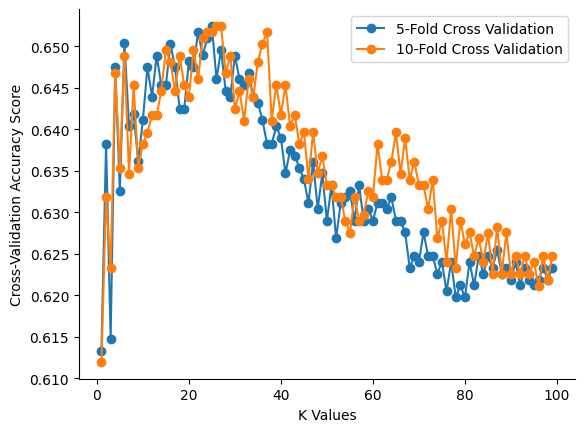

In [ ]:
plt.plot(k_values, scores5Train, label = "5-Fold Cross Validation", marker = 'o')
plt.plot(k_values, scores10Train, label = "10-Fold Cross Validation", marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Cross-Validation Accuracy Score")
plt.legend(loc='upper right')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
# calculate correlation coefficient
from scipy.stats import pearsonr
corr_k5, _ = pearsonr(k_values, scores5Train)
corr_k10, _ = pearsonr(k_values, scores10Train)
print('Pearsons correlation for cv=5: %.2f' % corr_k5)
print('Pearsons correlation for cv=10: %.2f' % corr_k10)

Pearsons correlation for cv=5: -0.77
Pearsons correlation for cv=10: -0.70


In [ ]:
# find best k value
best_index5_train = np.argmax(scores5Train)
best_k5_train = k_values[best_index5_train]
print('Best k value on train set for cv=5 is', best_k5_train, ' cv accuracy score is ', round(scores5Train[best_index5_train], 5))

best_index10_train = np.argmax(scores10Train)
best_k10_train = k_values[best_index10_train]
print('Best k value on train set for cv=10 is', best_k10_train, " cv accuracy score is ", round(scores10Train[best_index10_train], 5))


Best k value on train set for cv=5 is 25  cv accuracy score is  0.65245
Best k value on train set for cv=10 is 27  cv accuracy score is  0.65244


In [ ]:
# using the best k value to train model and evaluate
knn = [
    KNeighborsClassifier(n_neighbors=best_k5_train),
    KNeighborsClassifier(n_neighbors=best_k10_train),
  ]
knn_columns = []
knn_compare = pd.DataFrame(columns = knn_columns)

row_index = 0
for alg in knn:
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    knn_name = alg.__class__.__name__
    knn_compare.loc[row_index, 'Training Accuracy'] = round(alg.score(X_train, y_train), 5)
    knn_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    knn_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, predicted),5)
    knn_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    knn_compare.loc[row_index, 'AUC'] = round(auc(fp, tp),5)

    row_index+=1

knn_compare

,Training Accuracy,Test Accuracy,Precision,Recall,AUC
0,0.68017,0.65728,0.70175,0.31621,0.60967
1,0.68088,0.65563,0.70270,0.30830,0.60714
